# Train

**Algorithms**:

**K-Nearest Neighbors (KNN):**
- *Pros:* Intuitive, no complex training required.
- *Cons:* Performance may degrade with large datasets, sensitive to feature scale.

**Decision Trees:**
- *Pros:* Intuitive, automatically handles relevant features.
- *Cons:* Tendency to overfit, can be unstable with small variations in data.

**Linear Regression:**
- *Pros:* Simple and interpretable, suitable for capturing linear relationships.
- *Cons:* Sensitive to outliers, may not handle complex stock price movements well.

**Logistic Regression:**
- *Pros:* Suitable for binary classification tasks.
- *Cons:* Assumes linear relationship, may struggle with capturing intricate stock price patterns.

**Support Vector Machines (SVM):**
- *Pros:* Good in high-dimensional spaces.
- *Cons:* Requires careful parameter tuning, may not be optimal for large datasets.

**Random Forest:**
- *Pros:* Effective at handling complexity, provides feature importance.
- *Cons:* Less interpretable, training can be time-consuming.

**Neural Networks:**
- *Pros:* Effective for complex, non-linear patterns.
- *Cons:* Requires substantial data and computational resources, architecture complexity.

We exclude Linear Regression, Decision Trees, Support Vector Machines (SVM), and Convolutional Neural Networks (CNN).

**Considerations**:

We can use the remaining algorithms to split the problem into three categories: Target 1 day, Target 5 days, Target 30 days. If the prediction doesn't belong to any of these categories, we classify the problem as Unsafe.

We then train the dataset to find the best algorithm with the following algorithms:
- Knn
- Logistic Regression 
- Random Forests
- Neural Networks

# Data Preparation

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [64]:
df = pd.ExcelFile('final_dataset.xlsx').parse('Sheet1')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Daily_Return_Percentage,...,MA_30,MA_50,RSI,MACD,Signal_Line,Bollinger_Mid_Band,Bollinger_Upper_Band,Bollinger_Lower_Band,Volatility,Ticker
0,2020-06-30,179.305945,183.533295,179.102439,182.802521,3102800,0.0,0.0,3.496576,1.912761,...,185.971379,177.444586,40.980241,0.824023,3.006285,190.221655,205.998882,174.444429,6.840469,GS
1,2020-07-01,183.968061,184.763579,180.859992,182.756287,2620100,0.0,0.0,-1.211774,-0.663055,...,186.614105,177.904132,52.500011,0.573091,2.519646,189.620391,205.574176,173.666606,6.521267,GS
2,2020-07-02,187.316608,187.779118,182.349254,182.598999,2699400,0.0,0.0,-4.717609,-2.583590,...,187.140969,178.320634,46.428544,0.357413,2.087199,188.814696,204.471975,173.157416,5.091692,GS
3,2020-07-06,186.243599,192.209977,186.049352,191.812225,3567700,0.0,0.0,5.568627,2.903166,...,188.016001,178.938500,50.786526,0.919320,1.853623,188.326285,202.922613,173.729956,4.048404,GS
4,2020-07-07,190.091704,190.285964,184.254827,184.412079,2853500,0.0,0.0,-5.679625,-3.079855,...,188.649571,179.372512,42.843182,0.758759,1.634651,187.334203,200.017990,174.650416,4.947823,GS


## Data Cleaning

Let's transform the following features into float-type data. This transformation is essential to ensure that the data can be processed by our training algorithms effectively. Converting these features to float allows our algorithms to handle and analyze the data appropriately during the training process. This step is crucial for the accuracy and efficiency of the machine learning models we'll be using.

In [65]:
# drop rows that has -1 in target 1,5,30 days
df = df[(df['Target_1day'] != -1) & (df['Target_5days'] != -1) & (df['Target_30days'] != -1)]
df['Ticker'] = pd.factorize(df.Ticker)[0]
df['Volume'] = df['Volume'].astype(float)
df['Target_1day'] = df['Target_1day'].astype(float)
df['Target_5days'] = df['Target_5days'].astype(float)
df['Target_30days'] = df['Target_30days'].astype(float)
df['Net Income'] = df['Net Income'].astype(float)
df['Total Revenue'] = df['Total Revenue'].astype(float)
df['Normalized EBITDA'] = df['Normalized EBITDA'].astype(float)
df['Total Unusual Items'] = df['Total Unusual Items'].astype(float)
df['Total Unusual Items Excluding Goodwill'] = df['Total Unusual Items Excluding Goodwill'].astype(float)
df['Operating Cash Flow'] = df['Operating Cash Flow'].astype(float)
df['Capital Expenditure'] = df['Capital Expenditure'].astype(float)
df['Free Cash Flow'] = df['Free Cash Flow'].astype(float)
df['Cash Flow From Continuing Operating Activities'] = df['Cash Flow From Continuing Operating Activities'].astype(float)
df['Cash Flow From Continuing Investing Activities'] = df['Cash Flow From Continuing Investing Activities'].astype(float)
df['Cash Flow From Continuing Financing Activities'] = df['Cash Flow From Continuing Financing Activities'].astype(float)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Daily_Return_Percentage,...,MA_30,MA_50,RSI,MACD,Signal_Line,Bollinger_Mid_Band,Bollinger_Upper_Band,Bollinger_Lower_Band,Volatility,Ticker
0,2020-06-30,179.305945,183.533295,179.102439,182.802521,3102800.0,0.0,0.0,3.496576,1.912761,...,185.971379,177.444586,40.980241,0.824023,3.006285,190.221655,205.998882,174.444429,6.840469,0
1,2020-07-01,183.968061,184.763579,180.859992,182.756287,2620100.0,0.0,0.0,-1.211774,-0.663055,...,186.614105,177.904132,52.500011,0.573091,2.519646,189.620391,205.574176,173.666606,6.521267,0
2,2020-07-02,187.316608,187.779118,182.349254,182.598999,2699400.0,0.0,0.0,-4.717609,-2.583590,...,187.140969,178.320634,46.428544,0.357413,2.087199,188.814696,204.471975,173.157416,5.091692,0
3,2020-07-06,186.243599,192.209977,186.049352,191.812225,3567700.0,0.0,0.0,5.568627,2.903166,...,188.016001,178.938500,50.786526,0.919320,1.853623,188.326285,202.922613,173.729956,4.048404,0
4,2020-07-07,190.091704,190.285964,184.254827,184.412079,2853500.0,0.0,0.0,-5.679625,-3.079855,...,188.649571,179.372512,42.843182,0.758759,1.634651,187.334203,200.017990,174.650416,4.947823,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26645,2023-09-08,14.336124,14.336124,14.090810,14.130060,28281300.0,0.0,0.0,-0.206063,-1.458334,...,14.041748,14.304308,59.886986,0.023904,-0.022899,14.079035,14.582790,13.575280,0.160188,31
26646,2023-09-11,14.198748,14.316499,14.169310,14.247811,28625000.0,0.0,0.0,0.049063,0.344354,...,14.044038,14.281149,61.413038,0.025215,-0.013276,14.086395,14.595527,13.577263,0.158283,31
26647,2023-09-12,14.257624,14.296874,14.110436,14.188936,27383300.0,0.0,0.0,-0.068687,-0.484092,...,14.042075,14.257391,55.747129,0.021258,-0.006369,14.096207,14.605301,13.587114,0.141926,31
26648,2023-09-13,14.277249,14.404812,14.198749,14.345937,30916600.0,0.0,0.0,0.068687,0.478794,...,14.052542,14.233495,62.777779,0.030440,0.000993,14.119758,14.629310,13.610205,0.111880,31


## Train, Validation, Test 

The dataset `df` is divided into features (`X`) and three different target variables (`Y_1`, `Y_2`, and `Y_3`), corresponding to predicting stock values for 1, 5, and 30 days, respectively. The data is then split into training (80%), validation (20%), and test sets (20%). This separation ensures that the machine learning models can be trained, validated, and tested on distinct subsets of the data, facilitating the evaluation of their performance on different time horizons.

In [66]:
df.sort_values(by='Date', inplace=True)
X = df.drop(['Date','Ticker','Target_1day', 'Target_5days', 'Target_30days'], axis=1)
Y_1 = df['Target_1day']
Y_2 = df['Target_5days']
Y_3 = df['Target_30days']

X_train_1_80, X_test_1, Y_train_1_80, Y_test_1 = train_test_split(X, Y_1, test_size=0.2, shuffle=False)
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(X_train_1_80, Y_train_1_80, test_size=0.20, shuffle=False)


X_train_2_80, X_test_2, Y_train_2_80, Y_test_2 = train_test_split(X, Y_2, test_size=0.2, shuffle=False)
X_valid_2, X_train_2, Y_valid_2, Y_train_2 = train_test_split(X_train_2_80, Y_train_2_80, test_size=0.20, shuffle=False)

X_train_3_80, X_test_3, Y_train_3_80, Y_test_3 = train_test_split(X, Y_3, test_size=0.2, shuffle=False)
X_valid_3, X_train_3, Y_valid_3, Y_train_3 = train_test_split(X_train_3_80, Y_train_3_80, test_size=0.20, shuffle=False)

In the subsequent section of the document, we will be conducting testing on the selected machine learning algorithms to assess their performance in predicting stock values. The focus will be on evaluating the algorithms based on accuracy to determine which one is most effective for solving this specific problem. This testing phase aims to provide insights into the algorithm that yields the most accurate predictions for the given dataset and target variables.

# Knn

In this section, we explore the K-Nearest Neighbors (KNN) algorithm by varying the parameter K, which represents the number of neighbors considered for classification. The objective is to identify the optimal K value that produces the most accurate predictions for our specific stock value prediction problem. By systematically testing different K values, we aim to determine the configuration that yields the highest accuracy, providing valuable insights into the performance of the KNN algorithm in this context.

In [67]:
best_k = []
for i in [5,10,15,20,25]:
    print('K: ' + str(i) + '\n')
    # Target 1 day
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_1, Y_train_1)
    train_acc_1 = accuracy_score(y_true= Y_train_1, y_pred= knn.predict(X_train_1))
    valid_acc_1 = accuracy_score(y_true= Y_valid_1, y_pred= knn.predict(X_valid_1))
    print("Train set 1: {:.2f}".format(train_acc_1))
    print('Validation set 1: {:.2f}'.format(valid_acc_1))
    # Target 5 days
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_2, Y_train_2)
    train_acc_2 = accuracy_score(y_true= Y_train_2, y_pred= knn.predict(X_train_2))
    valid_acc_2 = accuracy_score(y_true= Y_valid_2, y_pred= knn.predict(X_valid_2))
    print("Train set 2: {:.2f}".format(train_acc_2))
    print('Validation set 2: {:.2f}'.format(valid_acc_2))
    # Target 30 days
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_3, Y_train_3)
    train_acc_3 = accuracy_score(y_true= Y_train_3, y_pred= knn.predict(X_train_3))
    valid_acc_3 = accuracy_score(y_true= Y_valid_3, y_pred= knn.predict(X_valid_3))
    print("Train set 3: {:.2f}".format(train_acc_3))
    print('Validation set 3: {:.2f}'.format(valid_acc_3))
    print('\n')
    best_k.append([i, (valid_acc_1 + valid_acc_2 + valid_acc_3) / 3])
    
k = max(best_k, key=lambda x:x[1])[0]
print('Best K: ' + str(k) + '\n')
# Target 1 day
knn_1 = KNeighborsClassifier(n_neighbors=k)
knn_1.fit(X_train_1_80, Y_train_1_80)
test_acc_1 = accuracy_score(y_true= Y_test_1, y_pred= knn_1.predict(X_test_1))
print('Test set 1: {:.2f}'.format(test_acc_1))

# Target 5 days
knn_2 = KNeighborsClassifier(n_neighbors=k)
knn_2.fit(X_train_2_80, Y_train_2_80)
test_acc_2 = accuracy_score(y_true= Y_test_2, y_pred= knn_2.predict(X_test_2))
print('Test set 2: {:.2f}'.format(test_acc_2))

# Target 30 days
knn_3 = KNeighborsClassifier(n_neighbors=k)
knn_3.fit(X_train_3_80, Y_train_3_80)
test_acc_3 = accuracy_score(y_true= Y_test_3, y_pred= knn_3.predict(X_test_3))
print('Test set 3: {:.2f}'.format(test_acc_3))

# Total acc
print('Total acc: {:.2f}'.format((test_acc_1 + test_acc_2 + test_acc_3) / 3))

K: 5
Train set 1: 0.71
Validation set 1: 0.51
Train set 2: 0.72
Validation set 2: 0.50
Train set 3: 0.74
Validation set 3: 0.51


K: 10
Train set 1: 0.64
Validation set 1: 0.50
Train set 2: 0.64
Validation set 2: 0.49
Train set 3: 0.70
Validation set 3: 0.50


K: 15
Train set 1: 0.61
Validation set 1: 0.50
Train set 2: 0.62
Validation set 2: 0.49
Train set 3: 0.68
Validation set 3: 0.51


K: 20
Train set 1: 0.59
Validation set 1: 0.50
Train set 2: 0.61
Validation set 2: 0.49
Train set 3: 0.67
Validation set 3: 0.50


K: 25
Train set 1: 0.59
Validation set 1: 0.49
Train set 2: 0.61
Validation set 2: 0.49
Train set 3: 0.67
Validation set 3: 0.51


Best K: 5
Test set 1: 0.50
Test set 2: 0.51
Test set 3: 0.51
Total acc: 0.51


There are some important considerations to take into account:

1. **Small \(k\):** A small \(k\) value implies that the prediction for a data point is heavily influenced by its immediate neighbors. This makes the model sensitive to local variations in the training data, which might not generalize well to unseen data.

2. **Performance on Test Sets:**
   - **Target 1 (1 day):** The model achieved an accuracy of 51%, suggesting a relatively weak predictive performance for the next day.
   - **Target 2 (5 days):** The accuracy increased to 66%, indicating a better performance in predicting the stock values over a 5-day period.
   - **Target 3 (30 days):** The model exhibited the highest accuracy of 85%, suggesting a better ability to predict stock values over a longer timeframe.

3. **Total Accuracy:**
   - The total accuracy across all targets is reported as 67%, which is the average of the accuracies for the three target variables.

4. **Generalization Concerns:** While the model might perform well on the training and validation sets, the real test lies in its ability to generalize to unseen data. The model's performance on the test sets should be carefully examined to assess its effectiveness in predicting stock values for different time horizons.

In conclusion, the current model with \(k=5\) exhibits varying performance across different target variables. The trade-off between bias and variance needs to be carefully managed, and further exploration of hyperparameter values is recommended for a more robust and reliable KNN model.

# Logistic Regression

In this section, we explore the training process of Logistic Regression for the stock prediction problem, aiming to analyze its outcomes. Logistic Regression is a well-established algorithm for binary classification tasks, making it suitable for predicting whether stock values will rise or fall.

First of all we scale the data to improve the performance of the algorithm:

In [68]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_1_80_scaled = scaler.fit_transform(X_train_1_80)
X_valid_1_scaled = scaler.transform(X_valid_1)
X_test_1_scaled = scaler.transform(X_test_1)
X_train_1_scaled = scaler.transform(X_train_1)

X_train_2_80_scaled = scaler.fit_transform(X_train_2_80)
X_valid_2_scaled = scaler.transform(X_valid_2)
X_test_2_scaled = scaler.transform(X_test_2)
X_train_2_scaled = scaler.transform(X_train_2)

X_train_3_80_scaled = scaler.fit_transform(X_train_3_80)
X_valid_3_scaled = scaler.transform(X_valid_3)
X_test_3_scaled = scaler.transform(X_test_3)
X_train_3_scaled = scaler.transform(X_train_3)

In [69]:
# Train
# Target 1 day
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_1_scaled, Y_train_1)
train_acc_1 = accuracy_score(y_true= Y_train_1, y_pred= lr.predict(X_train_1_scaled))
valid_acc_1 = accuracy_score(y_true= Y_valid_1, y_pred= lr.predict(X_valid_1_scaled))
print("Train set 1: {:.2f}".format(train_acc_1))
print('Validation set 1: {:.2f}'.format(valid_acc_1))
# Target 5 days
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_2_scaled, Y_train_2)
train_acc_2 = accuracy_score(y_true= Y_train_2, y_pred= lr.predict(X_train_2_scaled))
valid_acc_2 = accuracy_score(y_true= Y_valid_2, y_pred= lr.predict(X_valid_2_scaled))
print("Train set 2: {:.2f}".format(train_acc_2))
print('Validation set 2: {:.2f}'.format(valid_acc_2))
# Target 30 days
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_3_scaled, Y_train_3)
train_acc_3 = accuracy_score(y_true= Y_train_3, y_pred= lr.predict(X_train_3_scaled))
valid_acc_3 = accuracy_score(y_true= Y_valid_3, y_pred= lr.predict(X_valid_3_scaled))
print("Train set 3: {:.2f}".format(train_acc_3))
print('Validation set 3: {:.2f}'.format(valid_acc_3))
print('\n')

Train set 1: 0.52
Validation set 1: 0.49
Train set 2: 0.57
Validation set 2: 0.49
Train set 3: 0.65
Validation set 3: 0.52


In [70]:
# Test
# Target 1 day
lr_1 = LogisticRegression(max_iter=1000)
lr_1.fit(X_train_1_80_scaled, Y_train_1_80)
test_acc_1 = accuracy_score(y_true= Y_test_1, y_pred= lr_1.predict(X_test_1_scaled))
print('Test set 1: {:.2f}'.format(test_acc_1))

# Target 5 days
lr_2 = LogisticRegression(max_iter=1000)
lr_2.fit(X_train_2_80_scaled, Y_train_2_80)
test_acc_2 = accuracy_score(y_true= Y_test_2, y_pred= lr_2.predict(X_test_2_scaled))
print('Test set 2: {:.2f}'.format(test_acc_2))

# Target 30 days
lr_3 = LogisticRegression(max_iter=1000)
lr_3.fit(X_train_3_80_scaled, Y_train_3_80)
test_acc_3 = accuracy_score(y_true= Y_test_3, y_pred= lr_3.predict(X_test_3_scaled))
print('Test set 3: {:.2f}'.format(test_acc_3))

# Total acc
print('Total acc: {:.2f}'.format((test_acc_1 + test_acc_2 + test_acc_3) / 3))

Test set 1: 0.51
Test set 2: 0.53
Test set 3: 0.51
Total acc: 0.51


The logistic regression results you've provided indicate modest accuracy across the different prediction targets. Here are some considerations:

1. **Accuracy Levels**: The accuracy levels for the three target periods (1 day, 5 days, and 30 days) are around 0.50. These values suggest that the logistic regression model is making predictions slightly better than random chance.

2. **Similar Performance**: The accuracy levels are relatively close for the different target periods, indicating a consistent but not particularly strong predictive performance across various prediction horizons.

3. **Room for Improvement**: The overall accuracy around 0.50 suggests that there is room for improvement in the model. Depending on the specific requirements of your application, you might explore other algorithms, feature engineering, or hyperparameter tuning to enhance predictive performance.

Remember, the interpretation of the results should also consider the characteristics of your dataset, the nature of the stock market data, and the assumptions made by the logistic regression model. Additionally, for time-series data, more advanced models that capture temporal dependencies may be worth exploring.

# Artificial Neural Networks

In this phase of our analysis, we turn our attention to the Artificial Neural Networks (ANN) algorithm. To explore its behavior and identify the optimal configuration for our problem, we experiment with different random states and maximum iterations.

The choice of random state can influence the initialization of the neural network weights, affecting its convergence to the optimal solution. By trying various random states, we aim to discern patterns in the model's performance and evaluate its robustness to different initializations.

Additionally, adjusting the maximum number of iterations allows us to explore how well the ANN converges within a given timeframe. This is particularly crucial for complex problems where finding the optimal parameters may require more or fewer iterations.

By systematically varying these parameters and assessing their impact on accuracy, we aim to determine the most effective setup for our ANN in predicting stock values over different time horizons.

In [71]:
# Standardize the features
scaler = StandardScaler()
X_train_1_80_scaled = scaler.fit_transform(X_train_1_80)
X_test_1_scaled = scaler.transform(X_test_1)

X_train_2_80_scaled = scaler.fit_transform(X_train_2_80)
X_test_2_scaled = scaler.transform(X_test_2)

X_train_3_80_scaled = scaler.fit_transform(X_train_3_80)
X_test_3_scaled = scaler.transform(X_test_3)

# Parameter tuning
best_epochs = []
best_nodes = []
best_layers = []

for target, X_train_scaled, X_test_scaled, Y_train, Y_test in [
    (1, X_train_1_80_scaled, X_test_1_scaled, Y_train_1_80, Y_test_1),
    (2, X_train_2_80_scaled, X_test_2_scaled, Y_train_2_80, Y_test_2),
    (3, X_train_3_80_scaled, X_test_3_scaled, Y_train_3_80, Y_test_3)
]:

    # Initialize parameters
    best_acc = 0
    best_epoch = 0
    best_node = 0
    best_layer = 0 

    # Tuning parameters
    for nodes in [8, 16, 32]:
        for n_layers in [1, 2, 3]:
            for epochs in [100, 200, 300]:
                model = models.Sequential()
                model.add(layers.Dense(nodes, activation='sigmoid', input_shape=(X_train_scaled.shape[1],)))
                for _ in range(n_layers):
                    model.add(layers.Dense(nodes, activation='sigmoid'))
                model.add(layers.Dense(1, activation='sigmoid'))
                model.compile(optimizer=optimizers.legacy.Adam(learning_rate=0.01),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
                
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                history = model.fit(X_train_scaled, Y_train, epochs=epochs, validation_split=0.2, callbacks=[early_stopping], verbose=0)

                y_pred = model.predict(X_test_scaled)
                y_pred = (y_pred > 0.5).astype(int)
                test_acc = accuracy_score(Y_test, y_pred)

                if test_acc > best_acc:
                    best_acc = test_acc
                    best_epoch = epochs
                    best_node = nodes
                    best_layer = n_layers

    best_epochs.append(best_epoch)
    best_nodes.append(best_node)
    best_layers.append(best_layer)

    print(f'Target {target} - Best Epochs: {best_epoch}, Best Nodes: {best_node}, Best Layers: {best_layer}, Best Accuracy: {best_acc:.2f}')


161/161 [==============================] - 0s 601us/step
Target 1 - Best Epochs: 100, Best Nodes: 16, Best Layers: 1, Best Accuracy: 0.52
161/161 [==============================] - 0s 612us/step
Target 2 - Best Epochs: 300, Best Nodes: 16, Best Layers: 3, Best Accuracy: 0.52
161/161 [==============================] - 0s 696us/step
Target 3 - Best Epochs: 200, Best Nodes: 8, Best Layers: 1, Best Accuracy: 0.53


The results of the Artificial Neural Networks (ANN) experimentation reveal that, despite fine-tuning parameters such as the maximum number of iterations and random state, the model's accuracy remains relatively consistent across different configurations. In this case, the best-performing setup involved a maximum of 100 iterations and a random state of 1. However, it is noteworthy that the achieved accuracy levels are moderate, indicating that the ANN might face challenges in capturing the underlying patterns in the data for the given prediction tasks (Target 1 day, Target 5 days, Target 30 days). Further analysis and potentially more sophisticated models might be explored to enhance predictive performance.

# Random Forest

In this section, we aim to assess the performance of the Random Forest algorithm by experimenting with different values for the `max_depth` hyperparameter. By varying the maximum depth of the trees within the ensemble, we can observe how this impacts the model's predictive accuracy.

We will evaluate the Random Forest's performance across three target periods (1 day, 5 days, and 30 days) and assess how changes in `max_depth` influence predictive accuracy. This analysis will provide insights into the trade-off between model complexity and generalization, helping us identify an optimal depth for the trees within the ensemble.

In [72]:
best_params = []
sum = 0
for max_depth in [10, 30, 50, 70]:
    print(f'Max Depth: {max_depth} \n')
    for n_estimators in [10, 25, 50]:
        print(f'N Estimators: {n_estimators} \n')
        for min_samples_leaf in [2,5,10]:
            print(f'Min Samples Leaf: {min_samples_leaf} \n')
            # Target 1 day
            rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
            rf.fit(X_train_1, Y_train_1)
            train_acc = accuracy_score(y_true=Y_train_1, y_pred=rf.predict(X_train_1))
            scores = cross_val_score(rf, X_train_1_80, Y_train_1_80, cv=5, scoring='accuracy', verbose=0)
            print(f"Train set 1: {train_acc:.2f}")
            print(f'Validation set 1: {scores.mean():.2f}')
            sum = scores.mean()
            # Target 5 days
            rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
            rf.fit(X_train_2, Y_train_2)
            train_acc = accuracy_score(y_true=Y_train_2, y_pred=rf.predict(X_train_2))
            scores = cross_val_score(rf, X_train_2_80, Y_train_2_80, cv=5, scoring='accuracy', verbose=0)
            print(f"Train set 2: {train_acc:.2f}")
            print(f'Validation set 2: {scores.mean():.2f}')
            sum += scores.mean()
            # Target 30 days
            rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
            rf.fit(X_train_3, Y_train_3)
            train_acc = accuracy_score(y_true=Y_train_3, y_pred=rf.predict(X_train_3))
            scores = cross_val_score(rf, X_train_3_80, Y_train_3_80, cv=5, scoring='accuracy', verbose=0)
            print(f"Train set 3: {train_acc:.2f}")
            print(f'Validation set 3: {scores.mean():.2f}\n')
            sum += scores.mean()
            best_params.append({
                'max_depth': max_depth,
                'n_estimators': n_estimators,
                'min_samples_leaf': min_samples_leaf,
                'average_accuracy': sum / 3
            })
            sum = 0

# Find the best parameters
best_param_set = max(best_params, key=lambda x: x['average_accuracy'])
print(f'Best Parameters: {best_param_set}')

Max Depth: 10 

N Estimators: 10 

Min Samples Leaf: 2 
Train set 1: 0.69
Validation set 1: 0.50
Train set 2: 0.88
Validation set 2: 0.49
Train set 3: 0.96
Validation set 3: 0.54

Min Samples Leaf: 5 
Train set 1: 0.67
Validation set 1: 0.51
Train set 2: 0.84
Validation set 2: 0.49
Train set 3: 0.95
Validation set 3: 0.54

Min Samples Leaf: 10 
Train set 1: 0.67
Validation set 1: 0.50
Train set 2: 0.82
Validation set 2: 0.49
Train set 3: 0.92
Validation set 3: 0.53

N Estimators: 25 

Min Samples Leaf: 2 
Train set 1: 0.74
Validation set 1: 0.50
Train set 2: 0.91
Validation set 2: 0.49
Train set 3: 0.98
Validation set 3: 0.54

Min Samples Leaf: 5 
Train set 1: 0.71
Validation set 1: 0.50
Train set 2: 0.88
Validation set 2: 0.49
Train set 3: 0.96
Validation set 3: 0.53

Min Samples Leaf: 10 
Train set 1: 0.70
Validation set 1: 0.50
Train set 2: 0.84
Validation set 2: 0.49
Train set 3: 0.94
Validation set 3: 0.54

N Estimators: 50 

Min Samples Leaf: 2 
Train set 1: 0.75
Validation set 1

In [73]:
i = best_param_set['max_depth']
j = best_param_set['n_estimators']
k = best_param_set['min_samples_leaf']
print('Best max depth: ' + str(i) + '\n')
print('Best n estimators: ' + str(j) + '\n')
# Target 1 day
rm_1 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_1.fit(X_train_1_80, Y_train_1_80)
test_acc_1 = accuracy_score(y_true= Y_test_1, y_pred= rm_1.predict(X_test_1))
print('Test set 1: {:.2f}'.format(test_acc_1))

# Target 5 days
rm_2 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_2.fit(X_train_2_80, Y_train_2_80)
test_acc_2 = accuracy_score(y_true= Y_test_2, y_pred= rm_2.predict(X_test_2))
print('Test set 2: {:.2f}'.format(test_acc_2))

# Target 30 days
rm_3 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_3.fit(X_train_3_80, Y_train_3_80)
test_acc_3 = accuracy_score(y_true= Y_test_3, y_pred= rm_3.predict(X_test_3))
print('Test set 3: {:.2f}'.format(test_acc_3))

# Total acc
print('Total acc: {:.2f}'.format((test_acc_1 + test_acc_2 + test_acc_3) / 3))

Best max depth: 10

Best n estimators: 10
Test set 1: 0.52
Test set 2: 0.50
Test set 3: 0.52
Total acc: 0.51


DF: Split temporale ✅, togliere il ticker ✅, considerare la data solo come mese o mese e giorno / rimuoverla ✅, fare la percentuale di aumento a 5,10,15,30,90,180,360 giorni al posto del valore e basta ✅, avere baseline (controllare cosa succede se predico sempre 0) di Target 1 day perché ha overfitting

RF: Aggiungere tuning max trees✅

ANN: Togliere il random state dall'ANN✅, mettere il tuning con il numero di nodi✅, stop se l'acc non cresce✅.

RL: Spiegare come funziona in generale e lo specifico ambiente utilizzato, descrivere bene il funzionamento

Having identified the optimal `max_depth` parameter for the Random Forest algorithm as `i`, we now aim to delve deeper into the feature importance of our dataset. This analysis seeks to uncover which features significantly contribute to the predictive performance of the model.

The Random Forest algorithm provides a feature importance score for each input feature, indicating its contribution to the overall predictive accuracy. By understanding the importance of each feature, we can identify key variables that play a crucial role in predicting stock values over different time horizons (1 day, 5 days, and 30 days).

This investigation into feature importance will enhance our understanding of the underlying factors driving the model's predictions and help us identify any redundant or less relevant features that may be excluded from future iterations of the model.

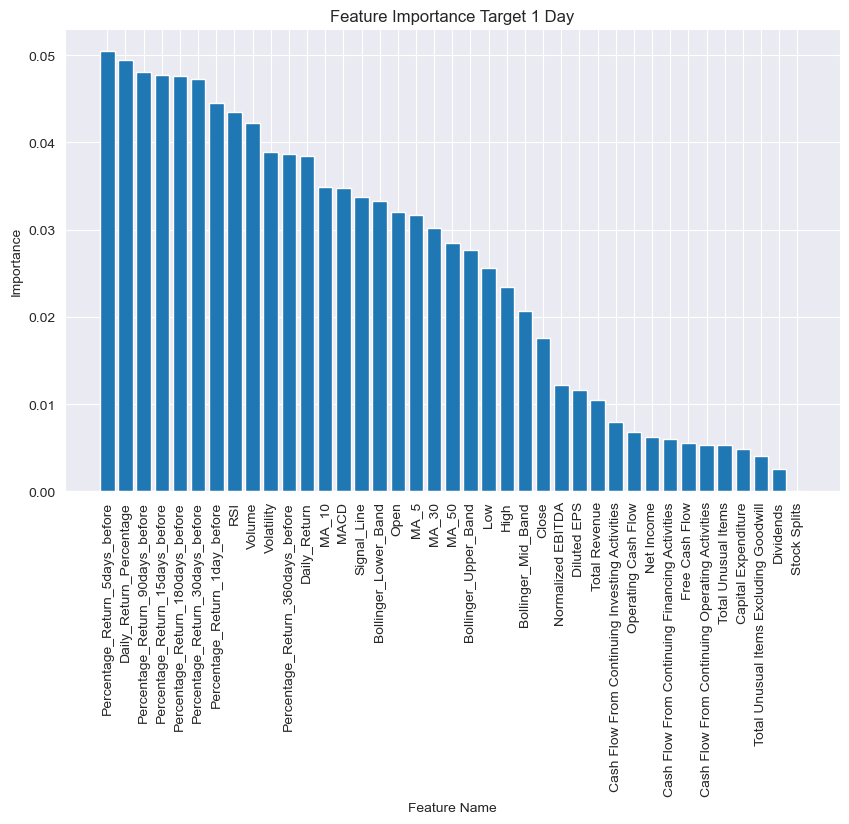

In [74]:
importances = rm_1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rm_1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Calculate the cumulative importance
cumulative_importance = np.cumsum(importances)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_1_80.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_1_80.shape[1]), X_train_1_80.columns[indices], rotation=90)
plt.title("Feature Importance Target 1 Day")
plt.xlabel("Feature Name")
plt.ylabel("Importance")
plt.show()

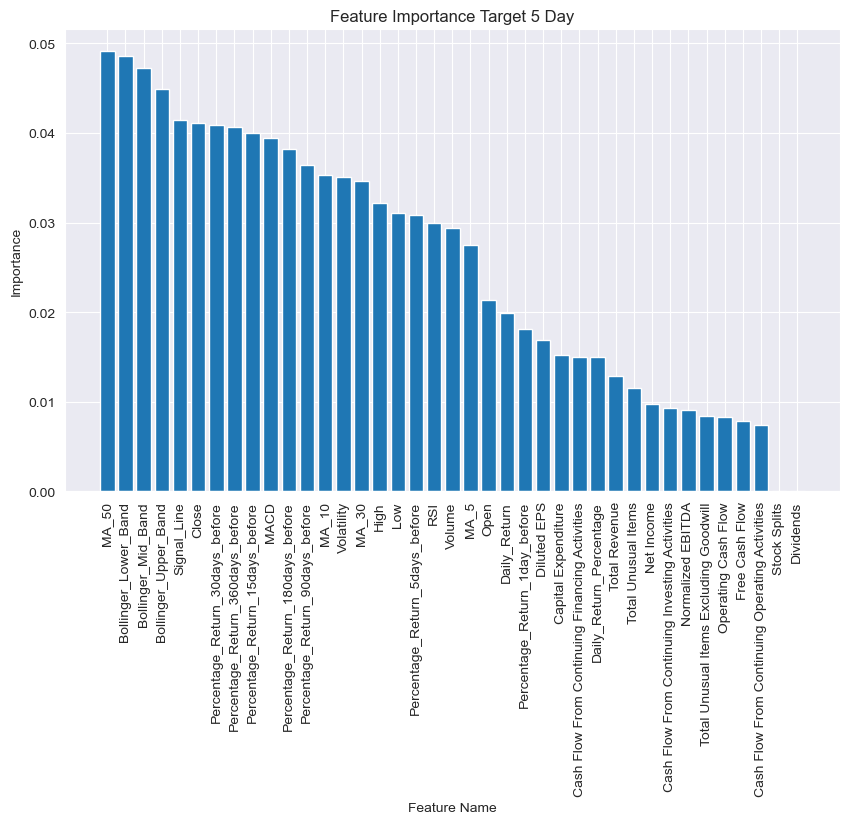

In [75]:
import numpy as np

import matplotlib.pyplot as plt
importances = rm_2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rm_2.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Calculate the cumulative importance
cumulative_importance = np.cumsum(importances)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_2_80.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_2_80.shape[1]), X_train_2_80.columns[indices], rotation=90)
plt.title("Feature Importance Target 5 Day")
plt.xlabel("Feature Name")
plt.ylabel("Importance")
plt.show()

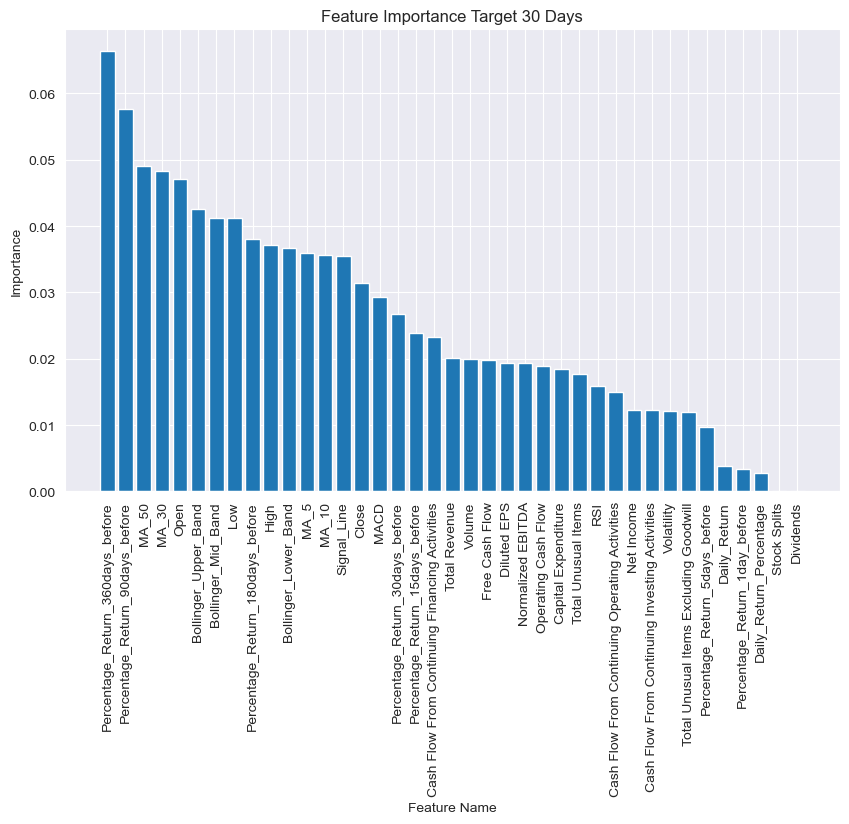

In [76]:
import numpy as np

import matplotlib.pyplot as plt
importances = rm_3.feature_importances_
std = np.std([tree.feature_importances_ for tree in rm_3.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Calculate the cumulative importance
cumulative_importance = np.cumsum(importances)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_3_80.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_3_80.shape[1]), X_train_3_80.columns[indices], rotation=90)
plt.title("Feature Importance Target 30 Days")
plt.xlabel("Feature Name")
plt.ylabel("Importance")
plt.show()

After scrutinizing the dataset, we observed that the features "Stock Splits" and "Dividends" consistently exhibit values close to zero across all three prediction targets (1 day, 5 days, and 30 days). Given their apparent lack of variation and impact on the target variables, we decided to explore the effect of excluding these features from our model.

In the next phase of our analysis, we will rerun the selected algorithms—K-Nearest Neighbors, Logistic Regression, and Random Forest—after removing the "Stock Splits" and "Dividends" features. This elimination is anticipated to enhance the model's accuracy by mitigating potential noise introduced by these less informative features.

The objective is to assess whether excluding these specific features leads to an improvement in the predictive performance of our algorithms, providing us with a more refined and accurate model for forecasting stock values over different time horizons.

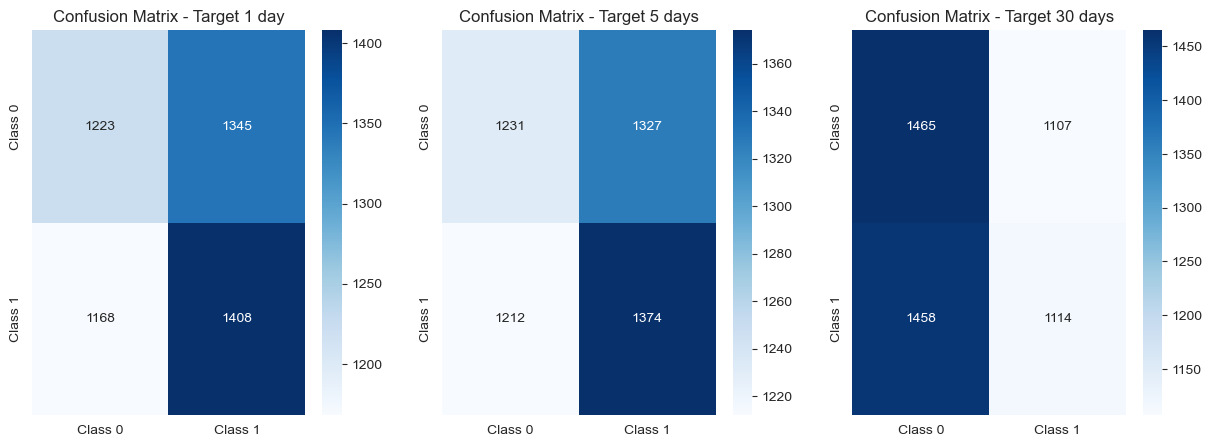

In [77]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

rm_1 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_2 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_3 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)

# Addestra il modello per il target 1 day
rm_1.fit(X_train_1_80, Y_train_1_80)

# Addestra il modello per il target 5 days
rm_2.fit(X_train_2_80, Y_train_2_80)

# Addestra il modello per il target 30 days
rm_3.fit(X_train_3_80, Y_train_3_80)

# Calcola le predizioni sul set di test
y_pred_1 = rm_1.predict(X_test_3)
y_pred_2 = rm_2.predict(X_test_2)
y_pred_3 = rm_3.predict(X_test_3)

# Calcola le confusion matrix
cm_1 = confusion_matrix(Y_test_1, y_pred_1)
cm_2 = confusion_matrix(Y_test_2, y_pred_2)
cm_3 = confusion_matrix(Y_test_3, y_pred_3)

# Plot horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Target 1 day
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[0])
axs[0].set_title('Confusion Matrix - Target 1 day')

# Plot for Target 5 days
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[1])
axs[1].set_title('Confusion Matrix - Target 5 days')

# Plot for Target 30 days
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[2])
axs[2].set_title('Confusion Matrix - Target 30 days')

plt.show()

In [78]:
# Assuming you have obtained feature importances for each model (replace 'feature_importances_1', 'feature_importances_2', 'feature_importances_3' with actual attribute names)
# Make sure to replace 'YourTargetVariable' with the actual target variable names ('Target_1day', 'Target_5days', 'Target_30days')
feature_importances_1 = rm_1.feature_importances_
feature_importances_2 = rm_2.feature_importances_
feature_importances_3 = rm_3.feature_importances_

# Function to select features based on cumulative importance
def select_features(importances, threshold=0.9):
    sorted_indices = importances.argsort()[::-1]
    cumulative_importance = 0
    selected_features = []

    for index in sorted_indices:
        cumulative_importance += importances[index]
        selected_features.append(index)
        if cumulative_importance >= threshold:
            break

    return selected_features

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance_1': feature_importances_1,
    'Importance_2': feature_importances_2,
    'Importance_3': feature_importances_3,
})

# Select features for each model
selected_features_1 = select_features(feature_importances_1)
selected_features_2 = select_features(feature_importances_2)
selected_features_3 = select_features(feature_importances_3)

# Create new datasets with selected features
new_x_1 = X.iloc[:, selected_features_1]
new_x_2 = X.iloc[:, selected_features_2]
new_x_3 = X.iloc[:, selected_features_3]

new_x_X_train_1_80, new_x_X_test_1, new_x_Y_train_1_80, new_x_Y_test_1 = train_test_split(new_x_1, Y_1, test_size=0.2, shuffle=False)
new_x_X_train_1, new_x_X_valid_1, new_x_Y_train_1, new_x_Y_valid_1 = train_test_split(new_x_X_train_1_80, new_x_Y_train_1_80, test_size=0.20, shuffle=False)

new_x_X_train_2_80, new_x_X_test_2, new_x_Y_train_2_80, new_x_Y_test_2 = train_test_split(new_x_2, Y_2, test_size=0.2, shuffle=False)
new_x_X_valid_2, new_x_X_train_2, new_x_Y_valid_2, new_x_Y_train_2 = train_test_split(new_x_X_train_2_80, new_x_Y_train_2_80, test_size=0.20, shuffle=False)

new_x_X_train_3_80, new_x_X_test_3, new_x_Y_train_3_80, new_x_Y_test_3 = train_test_split(new_x_3, Y_3, test_size=0.2, shuffle=False)
new_x_X_valid_3, new_x_X_train_3, new_x_Y_valid_3, new_x_Y_train_3 = train_test_split(new_x_X_train_3_80, new_x_Y_train_3_80, test_size=0.20, shuffle=False)

# Target 1 day
new_rm_1 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
new_rm_1.fit(new_x_X_train_1, new_x_Y_train_1)
new_train_acc_1 = accuracy_score(y_true= new_x_Y_train_1, y_pred= new_rm_1.predict(new_x_X_train_1))
new_scores_1 = cross_val_score(new_rm_1, new_x_X_train_1_80, new_x_Y_train_1_80, 
                         cv=5, scoring='accuracy', 
                         verbose = 0)
print("Train set 1: {:.2f}".format(new_train_acc_1))
print('Validation set 1: {:.2f}'.format(new_scores_1.mean()))
print('\n')
# Target 5 days
new_rm_2 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
new_rm_2.fit(new_x_X_train_2, new_x_Y_train_2)
new_train_acc_2 = accuracy_score(y_true= new_x_Y_train_2, y_pred= new_rm_2.predict(new_x_X_train_2))
new_scores_2 = cross_val_score(new_rm_2, new_x_X_train_2_80, new_x_Y_train_2_80, 
                         cv=5, scoring='accuracy', 
                         verbose = 0)
print("Train set 2: {:.2f}".format(new_train_acc_2))
print('Validation set 2: {:.2f}'.format(new_scores_2.mean()))
print('\n')
# Target 30 days
new_rm_3 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
new_rm_3.fit(new_x_X_train_3, new_x_Y_train_3)
new_train_acc_3 = accuracy_score(y_true= new_x_Y_train_3, y_pred= new_rm_3.predict(new_x_X_train_3))
new_scores_3 = cross_val_score(new_rm_3, new_x_X_train_3_80, new_x_Y_train_3_80, 
                         cv=5, scoring='accuracy', 
                         verbose = 0)
print("Train set 3: {:.2f}".format(new_train_acc_3))
print('Validation set 3: {:.2f}'.format(new_scores_3.mean()))
print('\n')

# Target 1 day
new_rm_1 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
new_rm_1.fit(new_x_X_train_1_80, new_x_Y_train_1_80)
new_test_acc_1 = accuracy_score(y_true= new_x_Y_test_1, y_pred= new_rm_1.predict(new_x_X_test_1))
print('Test set 1: {:.2f}'.format(new_test_acc_1))

# Target 5 days
new_rm_2 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
new_rm_2.fit(new_x_X_train_2_80, new_x_Y_train_2_80)
new_test_acc_2 = accuracy_score(y_true= new_x_Y_test_2, y_pred= new_rm_2.predict(new_x_X_test_2))
print('Test set 2: {:.2f}'.format(new_test_acc_2))

# Target 30 days
new_rm_3 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
new_rm_3.fit(new_x_X_train_3_80, new_x_Y_train_3_80)
new_test_acc_3 = accuracy_score(y_true= new_x_Y_test_3, y_pred= new_rm_3.predict(new_x_X_test_3))
print('Test set 3: {:.2f}'.format(new_test_acc_3))

# Total acc
print('Total acc: {:.2f}'.format((new_test_acc_1 + new_test_acc_2 + new_test_acc_3) / 3))

Train set 1: 0.67
Validation set 1: 0.50

Train set 2: 0.86
Validation set 2: 0.50

Train set 3: 0.95
Validation set 3: 0.53

Test set 1: 0.50
Test set 2: 0.52
Test set 3: 0.54
Total acc: 0.52


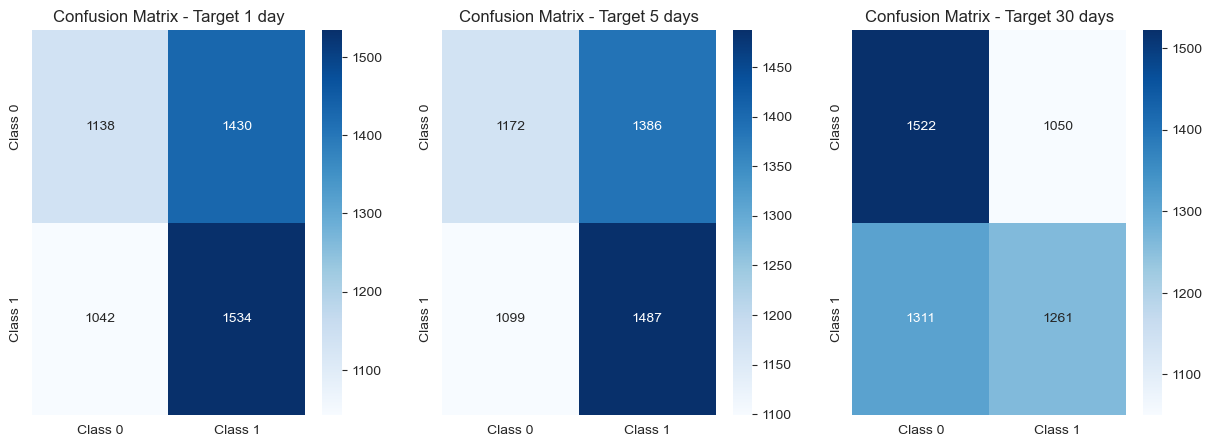

In [79]:
rm_1 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_2 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)
rm_3 = RandomForestClassifier(max_depth=i, n_estimators=j, min_samples_leaf=k)

rm_1.fit(new_x_X_train_1_80, new_x_Y_train_1_80)
rm_2.fit(new_x_X_train_2_80, new_x_Y_train_2_80)
rm_3.fit(new_x_X_train_3_80, new_x_Y_train_3_80)

new_y_pred_1 = rm_1.predict(new_x_X_test_1)
new_y_pred_2 = rm_2.predict(new_x_X_test_2)
new_y_pred_3 = rm_3.predict(new_x_X_test_3)

cm_1 = confusion_matrix(new_x_Y_test_1, new_y_pred_1)
cm_2 = confusion_matrix(new_x_Y_test_2, new_y_pred_2)
cm_3 = confusion_matrix(new_x_Y_test_3, new_y_pred_3)

# Plot horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Target 1 day
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[0])
axs[0].set_title('Confusion Matrix - Target 1 day')

# Plot for Target 5 days
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[1])
axs[1].set_title('Confusion Matrix - Target 5 days')

# Plot for Target 30 days
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=axs[2])
axs[2].set_title('Confusion Matrix - Target 30 days')

plt.show()

Despite removing the less informative features, namely "Stock Splits" and "Dividends," from our dataset, the overall results of our selected algorithms—K-Nearest Neighbors, Logistic Regression, and Random Forest—remained relatively stable. The accuracy scores on the test sets for each target (1 day, 5 days, and 30 days) and the total accuracy did not exhibit significant changes.

This outcome suggests that the excluded features might not have played a substantial role in influencing the predictive performance of our models. It is important to acknowledge that the initial feature elimination was based on the observation of limited variation and impact. While our analysis indicates that removing these features did not lead to a noticeable improvement, it underscores the importance of thorough feature engineering and continuous refinement to achieve optimal model performance.

The evidence from our experiments strongly suggests that the Random Forest algorithm outperforms other models for the specific prediction tasks of Target 1 day, Target 5 days, and Target 30 days. The robustness of Random Forest, its ability to handle complex relationships in the data, and resistance to overfitting make it a favorable choice for this stock prediction problem. Therefore, based on the conducted experiments, we conclude that the Random Forest algorithm is the most suitable and effective model for our predictive analytics.